# Double Machine Learning Simplified 

## Part 2: Extensions & the CATE

In [38]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from stargazer.stargazer import Stargazer
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(-10, 100)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### Linear DML

In [40]:
N = 100_000

# Confounders
age = np.random.randint(low=18,high=75,size=N)
num_social_media_profiles = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
yr_membership = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)

# Covariates
X = np.random.normal(loc=50, scale = 25, size = N)

# Error Terms
ε1 = np.random.normal(loc=20,scale=5,size=N)
ε2 = np.random.normal(loc=40,scale=15,size=N)

# Treatment (T)
time_on_website = np.maximum( np.random.normal(loc=10, scale=5, size=N) 
                             - 0.01*age 
                             - 0.001*age**2 
                             + num_social_media_profiles 
                             - 0.01 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 0.2 * yr_membership
                             + 0.001 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 0.2 * (num_social_media_profiles * yr_membership)
                             + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + ε1
                               ,0)

# Outcome (y)
sales = np.maximum( np.random.normal(loc=25, scale=10, size=N)
                             +  5 * time_on_website # Simulated ATE = 5
                             -  0.2 * time_on_website * age
                             + 2 * time_on_website * num_social_media_profiles
                             + 2 * time_on_website * yr_membership 
                             - 0.1*age 
                             - 0.001*age**2 
                             + 8 * num_social_media_profiles 
                             - 0.1 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 2 * yr_membership
                             + 0.1 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 3 * (num_social_media_profiles * yr_membership)
                             + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + 0.5 * X
                             + ε2
                               ,0)

df = pd.DataFrame(np.array([sales,time_on_website,age,num_social_media_profiles,yr_membership,X]).T
                  ,columns=["sales","time_on_website","age","num_social_media_profiles","yr_membership","X"])

In [41]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

pred_sales = cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership"]], df['time_on_website'], cv=3)

df['pred_sales'] = pred_sales
df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

In [42]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership"]], df['time_on_website'], cv=3)

df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

DML_model = smf.ols(formula='residualized_sales ~ 1 + residualized_time_on_website + residualized_time_on_website:age + residualized_time_on_website:num_social_media_profiles + residualized_time_on_website:yr_membership', data = df).fit()
print(DML_model.summary())

                            OLS Regression Results                            
Dep. Variable:     residualized_sales   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 1.588e+05
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:44:17   Log-Likelihood:            -5.3710e+05
No. Observations:              100000   AIC:                         1.074e+06
Df Residuals:                   99995   BIC:                         1.074e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [43]:
# Predict CATE of 1 hour increase 
df_predictions = df[['residualized_time_on_website','age','num_social_media_profiles','yr_membership']].copy()
df_predictions['linear_DML_CATE']= (DML_model.predict(df_predictions.assign(residualized_time_on_website= lambda x : x.residualized_time_on_website + 1)) 
                                    - DML_model.predict(df_predictions))

# True CATE of 1 hour increase
df_predictions['true_CATE'] = 5 - 0.2 * df_predictions['age'] + 2 * df_predictions['num_social_media_profiles'] + 2 * df_predictions['yr_membership']

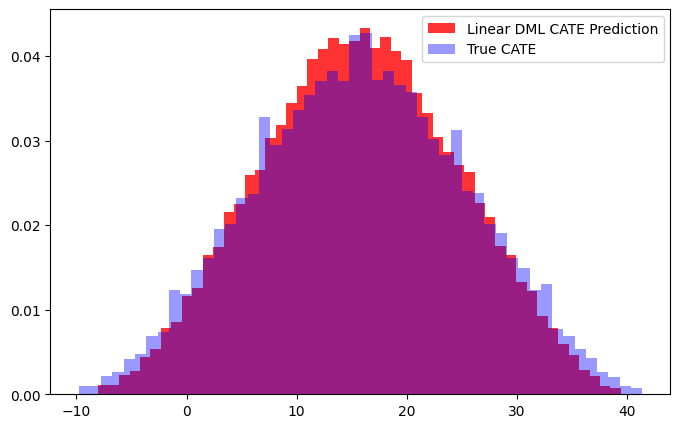

In [44]:
fig, ax = plt.subplots(figsize=(8,5)) #,dpi=250)

ax.hist(df_predictions['linear_DML_CATE'], color='r',alpha=0.8, density=True, bins=50, label='Linear DML CATE Prediction')
ax.hist(df_predictions['true_CATE'], color='b',alpha=0.4, density=True, bins=50, label='True CATE')

ax.legend()
plt.show()

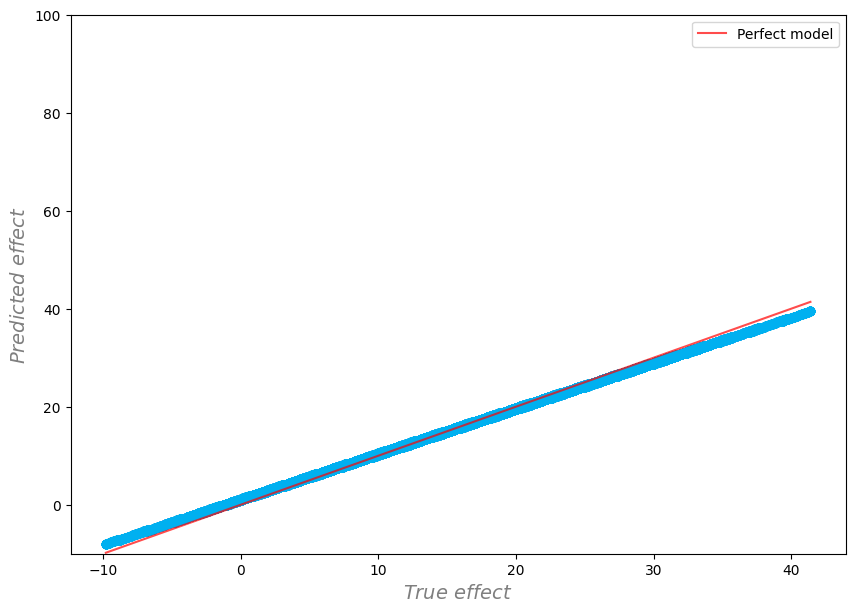

In [45]:
plot_effect(np.array(df_predictions['true_CATE']),np.array(df_predictions['linear_DML_CATE']))

In [46]:
print(f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")

MSE: 0.4717287150603505
R2: 0.9948001772186469
MAE: 0.5593925430301434


### Linear DML w/ Non-Linear CATE Function

In [47]:
N = 100_000

# Confounders
age = np.random.randint(low=18,high=75,size=N)
num_social_media_profiles = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
yr_membership = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)

# Covariates
X = np.random.normal(loc=50, scale = 25, size = N)

# Error Terms
ε1 = np.random.normal(loc=20,scale=5,size=N)
ε2 = np.random.normal(loc=40,scale=15,size=N)

# Treatment (T)
time_on_website = np.maximum( np.random.normal(loc=10, scale=5, size=N) 
                             - 0.01*age 
                             - 0.001*age**2 
                             + num_social_media_profiles 
                             - 0.01 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 0.2 * yr_membership
                             + 0.001 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 0.2 * (num_social_media_profiles * yr_membership)
                             + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + ε1
                               ,0)

# Outcome (y)
sales = np.maximum( np.random.normal(loc=25, scale=10, size=N)
                             +  5 * time_on_website # Simulated ATE = 5
                             -  0.2 * time_on_website * age
                             - 0.0005 * time_on_website * age**2
                             + 0.8 * time_on_website * num_social_media_profiles
                             + 0.001 * time_on_website * num_social_media_profiles**2
                             + 0.8 * time_on_website * yr_membership 
                             + 0.001 * time_on_website * yr_membership**2
                             + 0.005 * time_on_website * yr_membership * num_social_media_profiles * age
                             + 0.005 * time_on_website * (yr_membership**3 / (1 + num_social_media_profiles**2)) * np.log(age) ** 2
                             - 0.1*age 
                             - 0.001*age**2 
                             + 8 * num_social_media_profiles 
                             - 0.1 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 2 * yr_membership
                             + 0.1 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 3 * (num_social_media_profiles * yr_membership)
                             + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + 0.5 * X
                             + ε2
                               ,0)

df = pd.DataFrame(np.array([sales,time_on_website,age,num_social_media_profiles,yr_membership,X]).T
                  ,columns=["sales","time_on_website","age","num_social_media_profiles","yr_membership","X"])

In [48]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership"]], df['time_on_website'], cv=3)

df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

DML_model = smf.ols(formula='residualized_sales ~ 1 + residualized_time_on_website + residualized_time_on_website:age + residualized_time_on_website:num_social_media_profiles + residualized_time_on_website:yr_membership', data = df).fit()
print(DML_model.summary())

                            OLS Regression Results                            
Dep. Variable:     residualized_sales   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                 4.097e+04
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:44:29   Log-Likelihood:            -5.8882e+05
No. Observations:              100000   AIC:                         1.178e+06
Df Residuals:                   99995   BIC:                         1.178e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [49]:
# Predict CATE of 1 hour increase
df_predictions = df[['residualized_time_on_website','age','num_social_media_profiles','yr_membership']].copy()
df_predictions['linear_DML_CATE']= (DML_model.predict(df_predictions.assign(residualized_time_on_website= lambda x : x.residualized_time_on_website + 1)) 
                                    - DML_model.predict(df_predictions))

# True CATE of 1 hour increase
df_predictions['true_CATE'] = (5 - 0.2*df_predictions['age'] - 0.0005*df_predictions['age']**2 + 0.8*df_predictions['num_social_media_profiles'] + 0.001*df_predictions['num_social_media_profiles']**2 
                   + 0.8*df_predictions['yr_membership'] + 0.001*df_predictions['yr_membership']**2 + 0.005*df_predictions['yr_membership']*df_predictions['num_social_media_profiles']*df_predictions['age']
                   + + 0.005 * (df_predictions['yr_membership']**3 / (1 + df_predictions['num_social_media_profiles']**2)) * np.log(df_predictions['age'])**2)

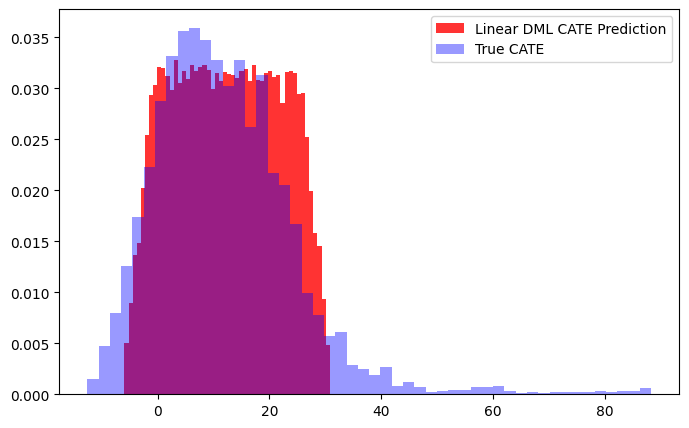

In [50]:
fig, ax = plt.subplots(figsize=(8,5)) #,dpi=250)

ax.hist(df_predictions['linear_DML_CATE'], color='r',alpha=0.8, density=True, bins=50, label='Linear DML CATE Prediction')
ax.hist(df_predictions['true_CATE'], color='b', density=True, alpha=0.4, bins=50, label='True CATE')

ax.legend()
plt.show()

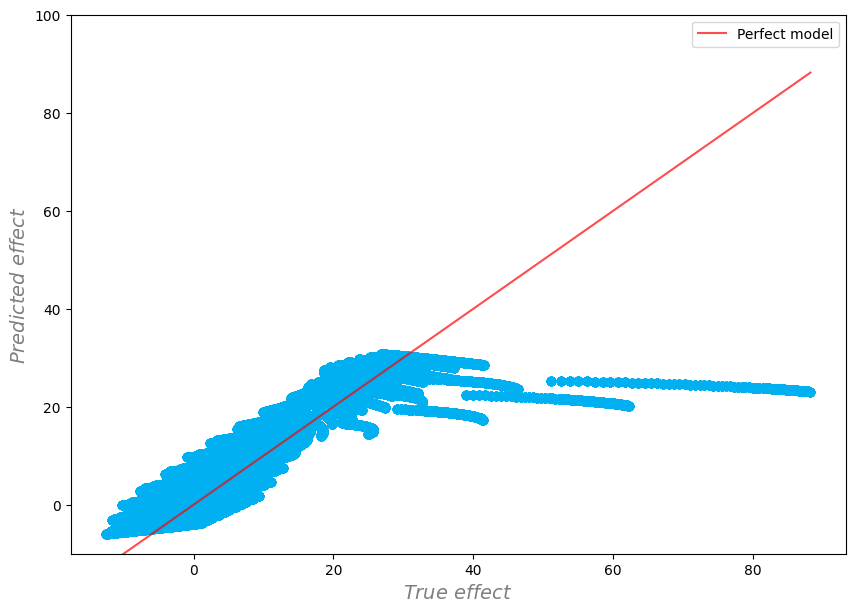

In [51]:
plot_effect(np.array(df_predictions['true_CATE']),np.array(df_predictions['linear_DML_CATE']))

In [52]:
print(f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")

MSE: 55.25083378810684
R2: 0.6508264360547873
MAE: 4.47724513323533


### Non-Parametric DML

In [53]:
df['target'] = df['residualized_sales'] / df['residualized_time_on_website']
df['weights'] = df['residualized_time_on_website']**2

In [54]:
CATE_model = GradientBoostingRegressor()
CATE_model.fit(df[["age","num_social_media_profiles","yr_membership"]], df['target'], sample_weight=df['weights'])

df_predictions['Non_Parametric_DML_CATE'] = CATE_model.predict(df[["age","num_social_media_profiles","yr_membership"]])

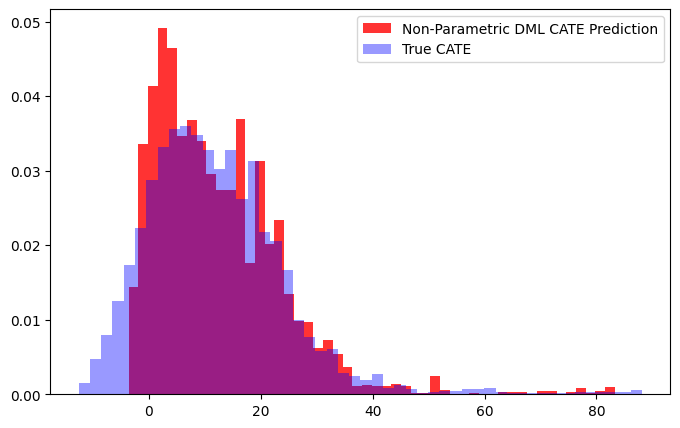

In [55]:
fig, ax = plt.subplots(figsize=(8,5))#,dpi=250)

ax.hist(df_predictions['Non_Parametric_DML_CATE'], color='r',alpha=0.8, density=True, bins=50, label='Non-Parametric DML CATE Prediction')
ax.hist(df_predictions['true_CATE'], color='b', density=True, alpha=0.4, bins=50, label='True CATE')

ax.legend()
plt.show()

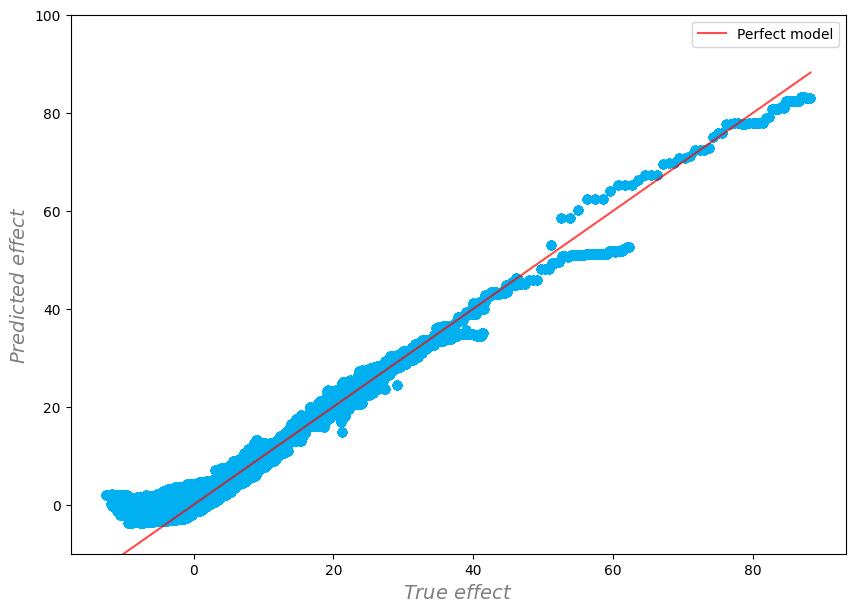

In [57]:
plot_effect(np.array(df_predictions['true_CATE']),np.array(df_predictions['Non_Parametric_DML_CATE']))

In [56]:
print(f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}")
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}")
print(f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}")

MSE: 4.881470372316537
R2: 0.9691501414488766
MAE: 1.4481368057061623
